In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from accelerate import Accelerator
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from scipy.ndimage import zoom
import random

import sys
sys.path.append("../")
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm
import nibabel as nb
import matplotlib.pyplot as plt
import functions_collection as ff
import Data_processing as dp

main_path = '/mnt/camca_NAS/Deepstrain/results'
patinet_info = pd.read_excel('/mnt/camca_NAS/SAM_for_CMR/data/Patient_list/HFpEF_fulldataset_basic_info_edited.xlsx')

## load the temporal strain

In [32]:
patient_id = 'ID_0002'
folders = ff.sort_timeframe(ff.find_all_target_files(['tf_*'],os.path.join(main_path,'strain',patient_id)), 0,'_','')
Ecc_aha_ori = np.zeros((len(folders),16))
Err_aha_ori = np.zeros((len(folders),16))
for i in range(len(folders)):
    strain_file = np.load(os.path.join(main_path,'strain',patient_id,folders[i],'strain_info.npy'),allow_pickle=True)
    ecc_aha = np.asarray(strain_file[-2][:-1] )
    err_aha = np.asarray(strain_file[-1][:-1] )
    Ecc_aha_ori[i] = ecc_aha
    Err_aha_ori[i] = err_aha

Ecc_aha = np.zeros((16, len(folders))); Err_aha = np.zeros((16, len(folders)))
for i in range(0,16):
    for j in range(len(folders)):
        Ecc_aha[i,j] = Ecc_aha_ori[j,i]
        Err_aha[i,j] = Err_aha_ori[j,i]



## sample 25 time frames

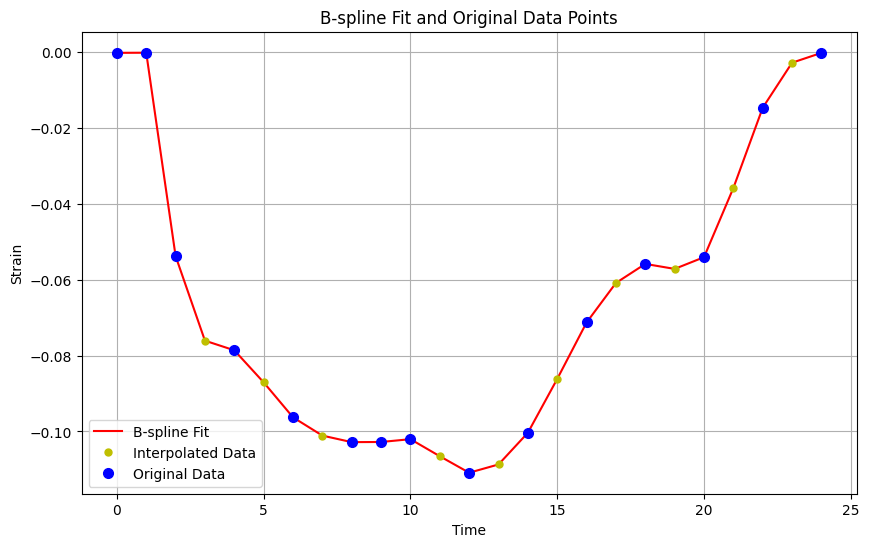

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import ast

# sample 25 time frames
row_in_info = patinet_info[patinet_info['patient_id'] == patient_id]
t_original = ast.literal_eval(row_in_info['processed_time_frame_index_list'].values[0])
t_original = [int(i) for i in t_original]; t_original = np.asarray(t_original)
t_new = np.arange(0, 25)

Ecc_aha_sample = np.zeros((16,25))
Err_aha_sample = np.zeros((16,25))


for i in range(16):
    spl_ecc = make_interp_spline(t_original, Ecc_aha[i,:], k=2)  # k=3表示三次样条
    ecc_new = spl_ecc(t_new)

    spl_err = make_interp_spline(t_original, Err_aha[i,:], k=2)  # k=3表示三次样条
    err_new = spl_err(t_new)

    Ecc_aha_sample[i] = ecc_new
    Err_aha_sample[i] = err_new


# # 绘制对比图
plt.figure(figsize=(10, 6))
plt.plot(t_new, Ecc_aha_sample[2,:], label='B-spline Fit', color='red')
plt.plot(t_new,Ecc_aha_sample[2,:], 'yo',markersize=5, label='Interpolated Data')
plt.plot(t_original, Ecc_aha[2,:], 'bo', markersize = 7,label='Original Data')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('B-spline Fit and Original Data Points')
plt.legend()
plt.grid(True)
plt.show()

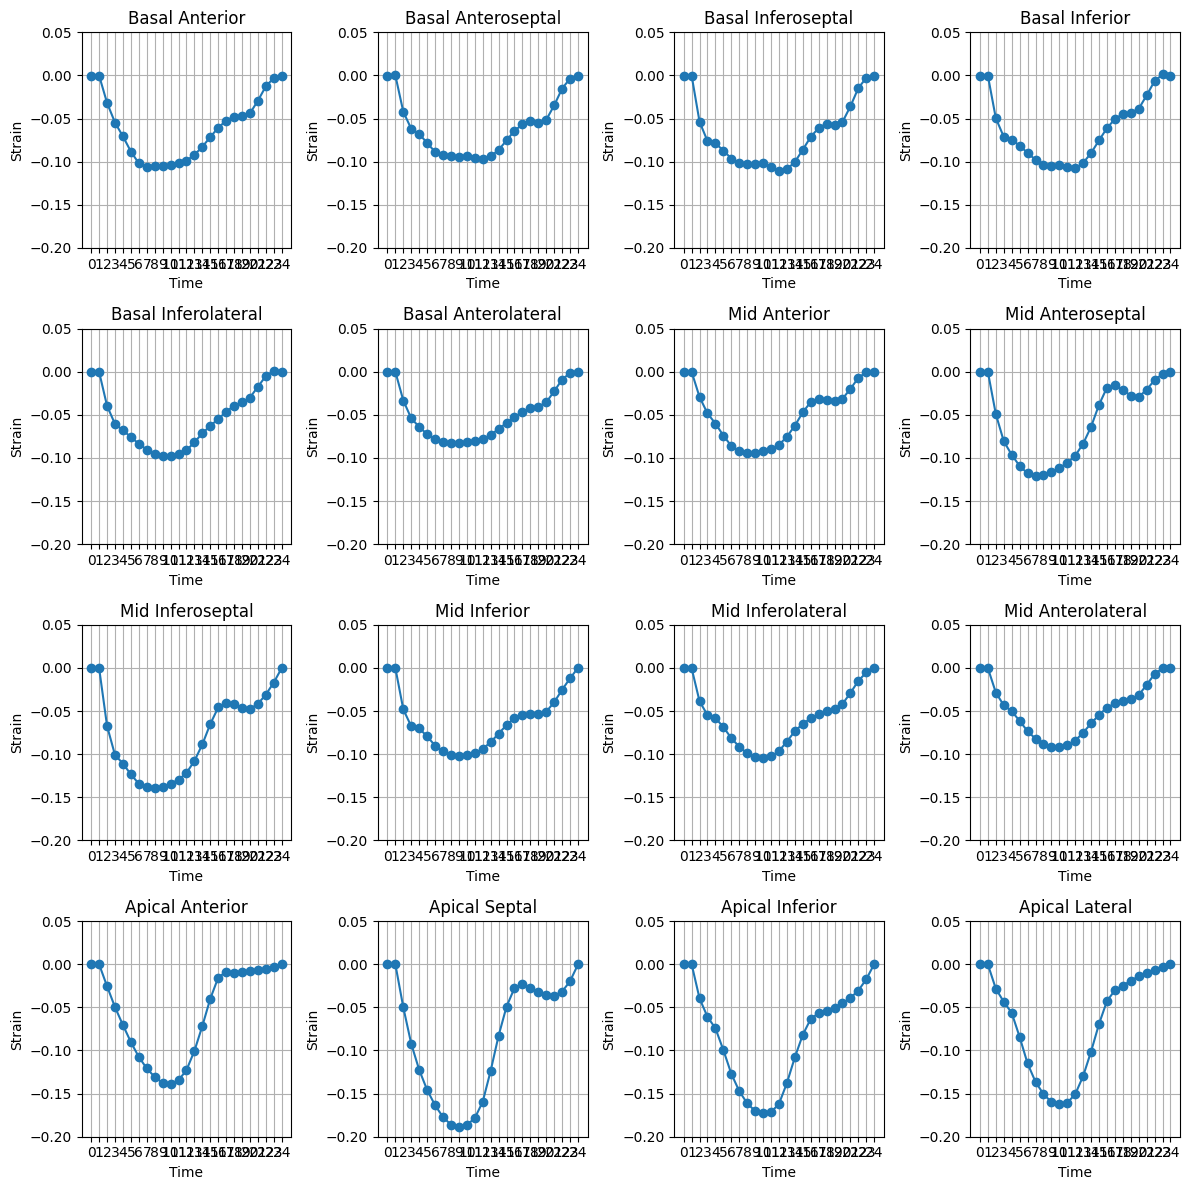

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your 16x15 array
# Each row represents a sample with 15 observations (strain values)
# Replace this with your actual data
# data = np.array([...])

# Example data for demonstration purposes (remove this when using your data)
# data = np.random.rand(16, 15)

data = Ecc_aha_sample

# Define the segment names for the AHA 16 segments
segment_names = [
    'Basal Anterior',
    'Basal Anteroseptal',
    'Basal Inferoseptal',
    'Basal Inferior',
    'Basal Inferolateral',
    'Basal Anterolateral',
    'Mid Anterior',
    'Mid Anteroseptal',
    'Mid Inferoseptal',
    'Mid Inferior',
    'Mid Inferolateral',
    'Mid Anterolateral',
    'Apical Anterior',
    'Apical Septal',
    'Apical Inferior',
    'Apical Lateral'
]

# Time points from 0 to 15 (total 16 points, but since your data has 15 observations, use 0 to 14)
time_points = np.arange(25)

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    axes[i].plot(time_points, data[i, :], marker='o')
    axes[i].set_title(segment_names[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Strain')
    axes[i].grid(True)
    axes[i].set_ylim(-0.20, 0.05)
    axes[i].set_xticks(time_points,fontsize=4)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


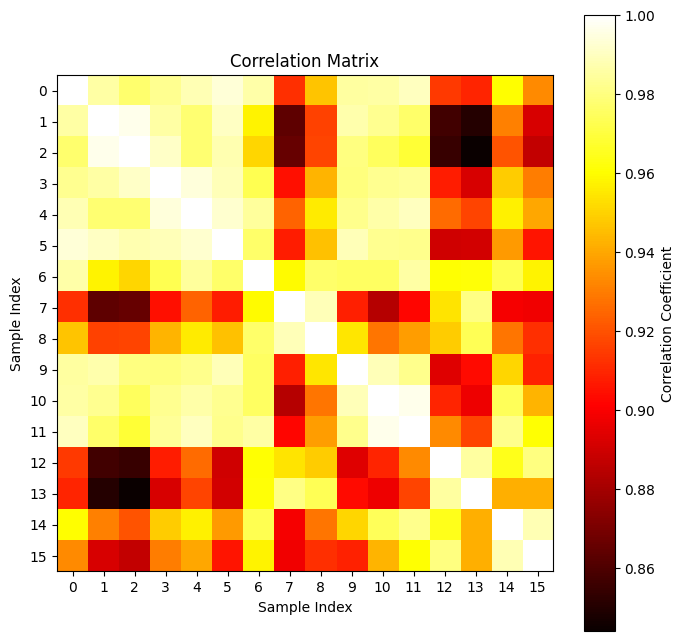

In [60]:
correlation_matrix = np.corrcoef(Ecc_aha_sample)
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.xticks(range(16))
plt.yticks(range(16))
plt.show()

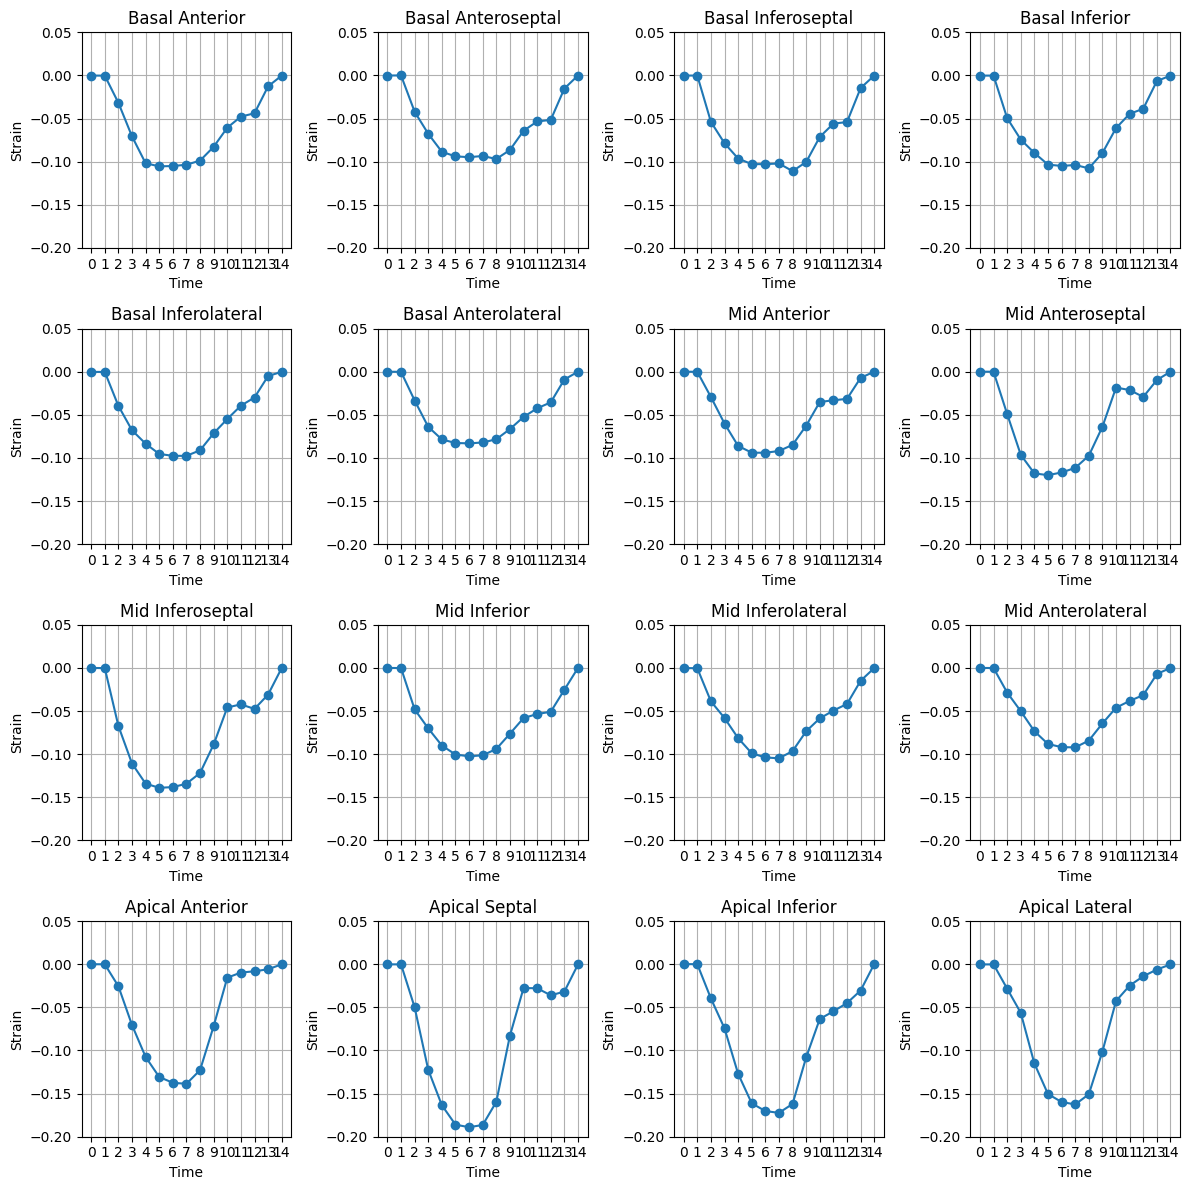

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is your 16x15 array
# Each row represents a sample with 15 observations (strain values)
# Replace this with your actual data
# data = np.array([...])

# Example data for demonstration purposes (remove this when using your data)
# data = np.random.rand(16, 15)

data = Ecc_aha

# Define the segment names for the AHA 16 segments
segment_names = [
    'Basal Anterior',
    'Basal Anteroseptal',
    'Basal Inferoseptal',
    'Basal Inferior',
    'Basal Inferolateral',
    'Basal Anterolateral',
    'Mid Anterior',
    'Mid Anteroseptal',
    'Mid Inferoseptal',
    'Mid Inferior',
    'Mid Inferolateral',
    'Mid Anterolateral',
    'Apical Anterior',
    'Apical Septal',
    'Apical Inferior',
    'Apical Lateral'
]

# Time points from 0 to 15 (total 16 points, but since your data has 15 observations, use 0 to 14)
time_points = np.arange(15)

# Create a 4x4 grid of plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i in range(16):
    axes[i].plot(time_points, data[i, :], marker='o')
    axes[i].set_title(segment_names[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Strain')
    axes[i].grid(True)
    axes[i].set_ylim(-0.20, 0.05)
    axes[i].set_xticks(time_points)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
